## Analysis of a WhatsApp chat

### Imports

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Preprocess file

In [2]:
# opens file, clears it from weird characters and saves result in new file
def preprocessFile(oldPath: str, newPath: str):
    with open(oldPath, encoding="utf-8") as origFile:
        data = origFile.read()

    data = removeZeroWidthSpace(data)
    data = escapeSpecialChars(data)
    data = convertTextToCSVFormat(data)

    with open(newPath, 'w', encoding="utf-8") as newFile:
        newFile.write(data)

# replace zero width character with empty character
def removeZeroWidthSpace(data: str):
    return data.replace(u'\u200b', "")

# escape special characters with \ to prevent messing with the data when converting
def escapeSpecialChars(data: str):
    data = data.replace("\\", r"\\")
    data = data.replace("\"", r"\"")
    data = data.replace("\'", r"\'")
    return data

# edit format of file to csv, add quotation marks around messages and end message with EXT (End of text)
def convertTextToCSVFormat(data: str):
    # Line format: Date, Time - Sender: Message
    # Allowed date format examples 24.12.24, 24.12.2024, 24/12/24, 24/12/2024
    pattern = re.compile(r"(?P<Timestamp>\d{2}[./]\d{2}[./](\d{2}|\d{4}), \d{2}:\d{2}) - (?P<Message>.*)")
    date, time, name, message = "Date", "Time", "Name", "Message"

    convertedData = []
    for line in data.split("\n"):
        newMessageRegex = pattern.match(line)

        # determine the parts of the message and save them to converted data as soon as a new message appears
        if newMessageRegex:
            convertedData.append(f"{date}, {time}, {name}, {message}\x03\n") # \x03 is the escape char for End of Text
            timestamp = newMessageRegex.group("Timestamp")
            information = newMessageRegex.group("Message")

            (date, time) = splitTimeStamp(timestamp)
            (name, message) = splitInformation(information)
        # the message continues at a new line, add them to the current message
        else: 
            message += "\n" + line

    return "\n".join(convertedData)

def splitTimeStamp(timestamp: str):
    # convert to date object
    datetime = pd.to_datetime(timestamp, format="mixed", dayfirst=True)

    return (datetime.date(), datetime.time())

def splitInformation(information: str):
    # sender name is either the contact name or a telephone number
    informationRegex = re.match(r"(?P<Sender>([\w\s]+|([\+\d\s]+))): (?P<Text>.*)", information)

    # if there is no sender, the message has been an information from the WhatsApp application
    # example: X has left the chat
    if not informationRegex:
        return ("WhatsApp", information)

    return (informationRegex.group("Sender"), informationRegex.group("Text"))

# converts our preprocessed file into a pandas dataframe
def convertFileToDataframe(path: str):
    df = pd.read_csv(path, usecols=range(4), skipinitialspace=True, lineterminator="\x03", encoding="utf-8")
    
    # show full length of message when printing
    pd.set_option("max_colwidth", None)
    pd.set_option("max_seq_item", None)
    
    df = df.iloc[:-1] # remove last entry, because it is an empty line
    return df


### Postprocess data

In [3]:
# cleans the dataframe after creation
def postprocessData(df: pd.DataFrame):
    # clean data
    removeBeginningSpecialChars(df)
    revertEscapedChars(df)

    # add new data
    addColumnMessageLength(df)
    addColumnNumberOfWords(df)

    # replace false data
    replaceNanMessages(df)
    return df

# removes the beginning \r\n from the dates
def removeBeginningSpecialChars(df: pd.DataFrame):
    df["Date"] = df["Date"].replace(r"\r\n", "", regex=True)
    return df

# removes the \ from escaped chars in message
def revertEscapedChars(df: pd.DataFrame):
    # I don't exactly know why this one works, but it works
    df["Message"] = df["Message"].replace(r"\\\\", "\\\\", regex=True)
    df["Message"] = df["Message"].replace(r"\\\"", "\"", regex=True)
    df["Message"] = df["Message"].replace(r"\\\'", "\'", regex=True)

# adds length of message as a column to dataframe
def addColumnMessageLength(df: pd.DataFrame):
    df["Message length"] = df["Message"].str.len()

# adds number of words in message as a column
def addColumnNumberOfWords(df: pd.DataFrame):
    df["Message word count"] = df["Message"].apply(lambda x: len(str(x).split(' ')))

# changes messages which are NaN to the correct ones: One time messages
def replaceNanMessages(df: pd.DataFrame):
    df["Message"] = df["Message"].fillna("<Media omitted>")
    df["Message length"] = df["Message length"].fillna(15)
    df["Message word count"] = df["Message word count"].fillna(2)

### Implementation of the statistical analysis methods

In [4]:
# count how many messages everyone sent
def countMessagesByName(df: pd.DataFrame):
    return df.groupby("Name")["Message"] \
             .count() \
             .sort_values(ascending=False)

# count how many words everyone sent
def countWordsByName(df: pd.DataFrame):
    return df.groupby("Name")["Message word count"] \
             .sum() \
             .sort_values(ascending=False)

# calculate the average number of words per message
def calcAvrgWordsPerMessage(df: pd.DataFrame):
    data = df.groupby("Name") \
        .agg({
            "Message": "count",
            "Message length": "sum",
            "Message word count": "sum"
        })
    
    data["length/message"] = data["Message length"] / data["Message"]
    data["words/message"] = data["Message word count"] / data["Message"]
    return data.sort_values(by="Message", ascending=False)

# returns the frequency of words a member of the group has said
def getUserWordFrequency(df: pd.DataFrame, name: str = "", top_n: int = 100):
    # filter by name or select messages sent by all
    if name == "":
        userMsg = df
    else:
        userMsg = df[df["Name"] == name]

    # drop message <Media omitted> and <Medien ausgeschlossen> (german)
    userMsg = userMsg[(userMsg["Message"] == "<Media omitted>") == False]
    userMsg = userMsg[(userMsg["Message"] == "<Medien ausgeschlossen>") == False]

    # ignore if word is in upper or lowercase
    # remove chained assignment: userMsg["Message"] = userMsg["Message"].str.lower()
    userMsg.loc[:,"Message"] = userMsg.loc[:, "Message"].str.lower()

    # source: https://stackoverflow.com/questions/64022617/counting-occurrences-of-word-in-a-string-in-pandas
    # give every word its own row
    userMsg = userMsg.assign(word = userMsg["Message"].str.split()) \
                            .explode("word")

    # remove special chars before or after words
    userMsg["word"] = userMsg["word"].str.strip(",:().*?!")

    # count all occurrences of words in the messages
    counts = userMsg[["word", "Message word count"]] \
                .groupby("word").count() \
                .sort_values(by="Message word count", ascending=False)

    counts = counts.reset_index()

    return counts.head(top_n)

def getMessageFrequencyPerHour(df: pd.DataFrame, plot: bool = False):
    data = df[["Time", "Name", "Message"]]
    
    # set time of every message to full hour
    hour_value = pd.to_datetime(data["Time"], format="%H:%M:%S")
    hour_value = hour_value.dt.hour
    data.loc[:, "Time"] = hour_value

    # count the messages sent in this hour
    data = data.groupby("Time")["Message"].count().to_frame()
    if plot:
        data.plot(kind="bar", title= "Number of messages per hour", xlabel="Hour", ylabel="Messages sent")
    return data

def getMessageFrequencyPerMemberPerHour(df: pd.DataFrame, plot: bool = False):
    data = df[["Time", "Name", "Message"]]

    # set time of every message to full hour
    hour_value = pd.to_datetime(data["Time"], format="%H:%M:%S")
    hour_value = hour_value.dt.hour
    data.loc[:, "Time"] = hour_value

    # count the messages sent in this hour
    data = data.groupby(["Name", "Time"])["Message"].count().to_frame()
    
    # pivot table for more compact display
    data.reset_index(inplace=True)
    data = pd.pivot_table(data=data, index='Time', columns='Name', values='Message')
    
    # fill NaN with 0 and change datatype back to int
    data = data.fillna(0).astype(int)
    
    if plot:
        numberOfUsers = df["Name"].nunique()
        data.plot(kind="bar", title = "Number of messages per hour per user", subplots=True, 
                  legend=False, figsize=(10, 3 * numberOfUsers), ylabel="Number of messages")
    return data

def getMessageFrequencyPerDay(df: pd.DataFrame):
    msgPerDay = df.groupby("Date")["Date"] \
                .count() \
                .reset_index(name="Number of messages")
    
    # save Date as Datetime object to better sort 
    msgPerDay["Date"] = pd.to_datetime(msgPerDay["Date"])
    msgPerDay = msgPerDay.sort_values(by="Date")

    return msgPerDay

def plotAvrgNumberOfMessagesInTimeFrame(df: pd.DataFrame, time_frame: str):
    # per day
    if time_frame == "Day":
        msgPerDay = getMessageFrequencyPerDay(df)
        msgPerDay["Date"] = msgPerDay["Date"].dt.dayofweek
        msgPerDay = msgPerDay.groupby("Date").mean()

        day_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
        plot = msgPerDay.plot.bar(xlabel="Weekday", title = "Average number of messages per day of the week",
                                  ylabel="Number of messages sent")
        plot.set_xticklabels(day_names)
        return plot

    # per week
    if time_frame == "Week":
        msgPerWeek = getMessageFrequencyPerDay(df)
        msgPerWeek["Date"] = msgPerWeek["Date"].dt.isocalendar().week
        msgPerWeek = msgPerWeek.groupby("Date").mean()

        return msgPerWeek.plot.bar(xlabel="Week", title= "Average number of messages for every week of the year",
                                   ylabel="Number of messages sent", figsize=(20,10))

    # per month
    if time_frame == "Month":
        msgPerMonth = getMessageFrequencyPerDay(df)
        msgPerMonth["Date"] = msgPerMonth["Date"].dt.month
        msgPerMonth = msgPerMonth.groupby("Date").mean()

        month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
        plot = msgPerMonth.plot.bar(xlabel="Month", title= "Average number of messages for every month of the year",
                                    ylabel="Number of messages sent")
        plot.set_xticklabels(month_names)
        return plot

def showUseOfWordsOverTime(df: pd.DataFrame, word: str, time_frame_in_days: int, name: str = ""):
    # use only the messages of a certain person if specified
    if name:
        df = df[df["Name"] == name]
    
    # set the date as the index
    df.loc[:, "Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"])
    df = df.sort_values(by="Datetime")
    df.index = df["Datetime"]

    # filter out the messages where one of the words are mentioned
    word_mentions = df[df["Message"].str.contains(word, na=False)]

    # create rolling window of mentions
    word_rolling = word_mentions["Message"].rolling(str(time_frame_in_days) + "D").count()

    # plot the rolling series
    return word_rolling.plot(kind="line")

### Run the analysis script

In [5]:
# analyses an export of a WhatsApp Chat
origFilePath = "example.txt"
preprocessedFilePath = "Chats/Preprocessed" + origFilePath
origFilePath = "Chats/" + origFilePath

# processing data
preprocessFile(origFilePath, preprocessedFilePath)
df = convertFileToDataframe(preprocessedFilePath)
df = postprocessData(df)

In [6]:
# show a part of the dataframe
df.head(10)

,Date,Time,Name,Message,Message length,Message word count
0,2024-04-23,15:56:00,WhatsApp,Messages and calls are end-to-end encrypted.,44.0,6
1,2024-04-23,15:56:00,WhatsApp,"B created group ""GroupName""",27.0,4
2,2024-04-23,15:56:00,WhatsApp,B added you,11.0,3
3,2024-04-23,15:57:00,B,do you want to meet on the weekend or is weekday okay?😃,55.0,12
4,2024-04-23,16:00:00,A,Both is fine,12.0,3
5,2024-04-23,16:01:00,C,Weekdays works too,18.0,3
6,2024-04-23,16:01:00,B,i’m fine with weekdays too,26.0,5
7,2024-04-23,16:03:00,B,is this saturday too soon?,26.0,5
8,2024-04-23,16:03:00,C,No,2.0,1
9,2024-04-23,16:03:00,C,At least not for me,19.0,5


### Run the different statistics

In [7]:
display(countMessagesByName(df))

Name
C           5059
B           4807
A           3395
D            873
WhatsApp      10
Name: Message, dtype: int64

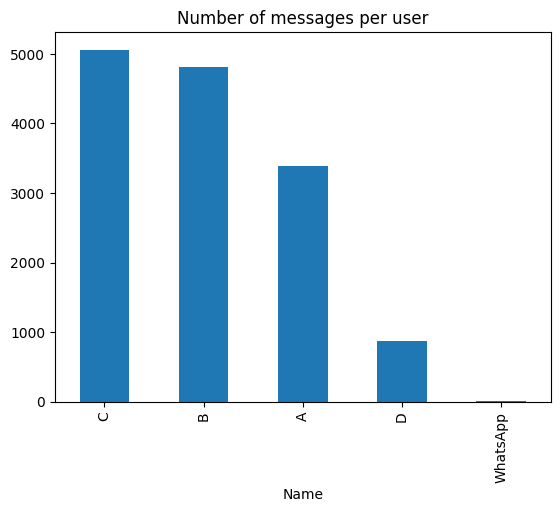

In [8]:
countMessagesByName(df).plot(kind="bar", title="Number of messages per user");

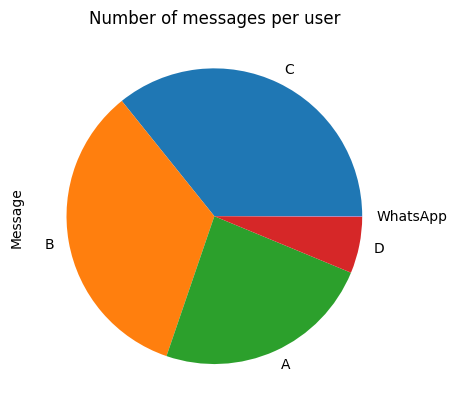

In [9]:
countMessagesByName(df).plot(kind="pie", title="Number of messages per user");

In [10]:
countWordsByName(df)

Name
C           20827
B           18771
A           16003
D            3355
WhatsApp       45
Name: Message word count, dtype: int64

<Axes: title={'center': 'Number of words per user'}, xlabel='Name'>

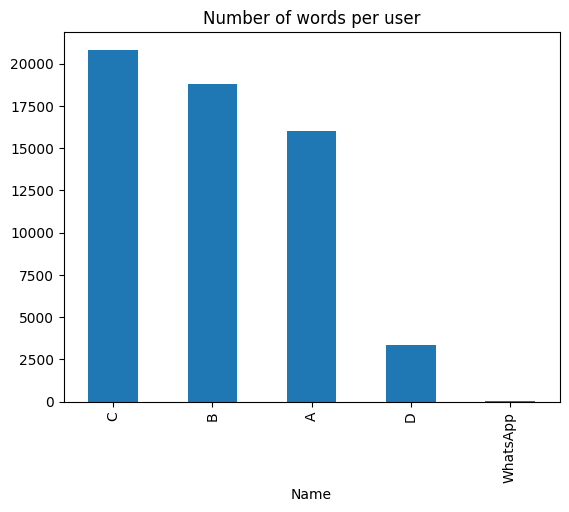

In [11]:
countWordsByName(df).plot(kind="bar", title="Number of words per user")

<Axes: title={'center': 'Number of words per user'}, ylabel='Message word count'>

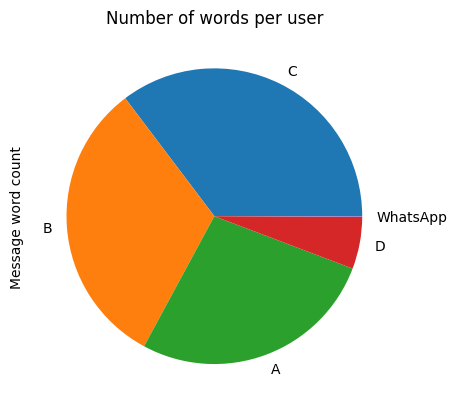

In [12]:
countWordsByName(df).plot(kind="pie", title="Number of words per user")

In [13]:
calcAvrgWordsPerMessage(df)

,Message,Message length,Message word count,length/message,words/message
Name,,,,,
C,5059,112811.0,20827,22.299071,4.116822
B,4807,97599.0,18771,20.303516,3.904930
A,3395,89221.0,16003,26.280118,4.713697
D,873,17627.0,3355,20.191294,3.843070
WhatsApp,10,255.0,45,25.500000,4.500000


In [14]:
# show the whole output
with pd.option_context('display.max_rows', None):
    display(getUserWordFrequency(df))

,word,Message word count
0,ich,2198
1,ist,1019
2,das,994
3,nicht,948
4,und,834
5,du,829
6,die,653
7,so,642
8,aber,542
9,was,494


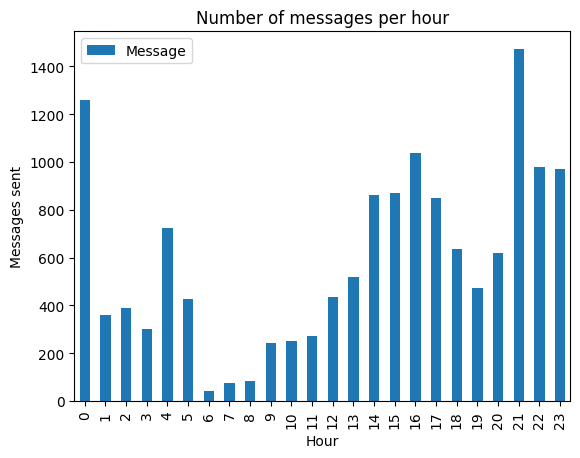

In [15]:
getMessageFrequencyPerHour(df, plot=True);

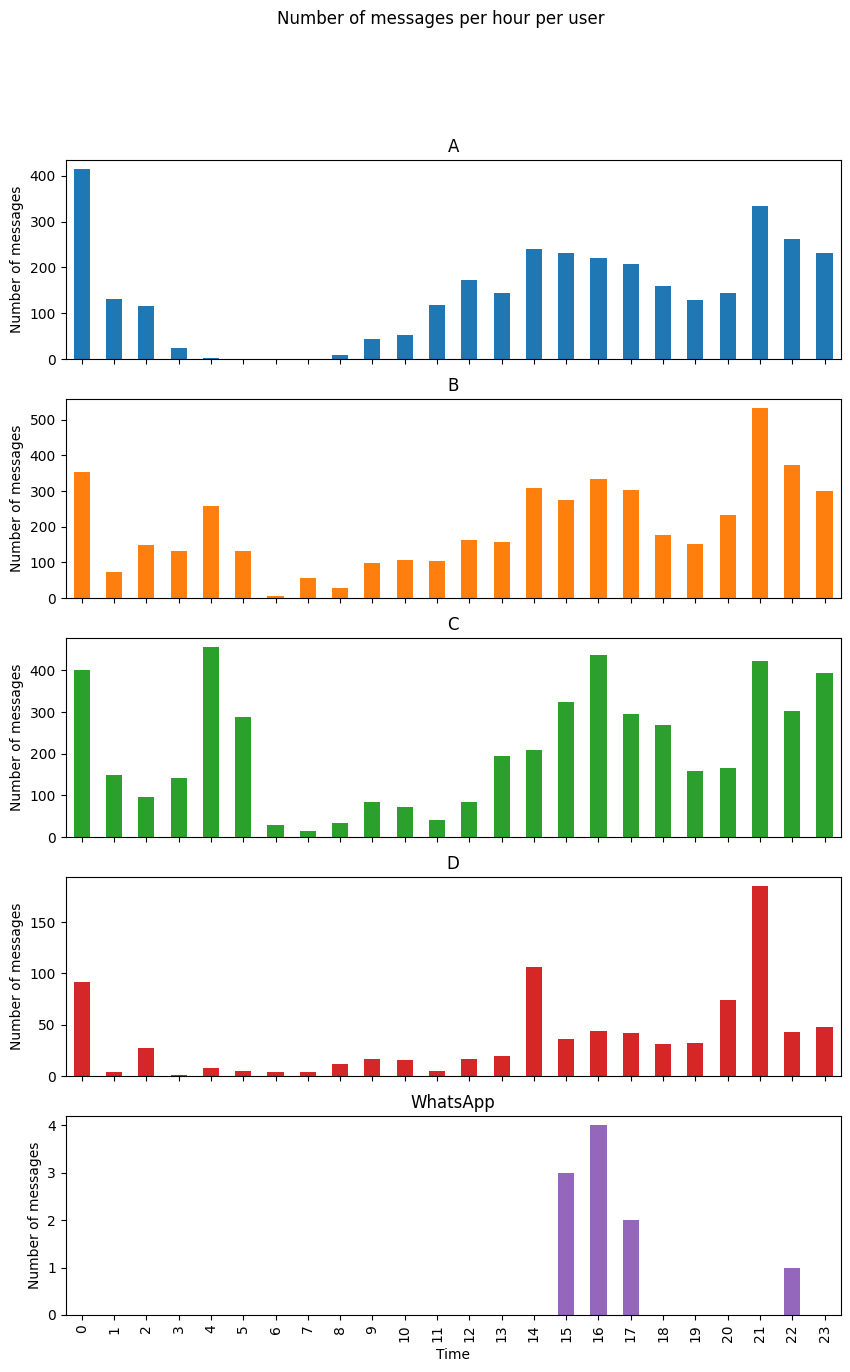

In [16]:
getMessageFrequencyPerMemberPerHour(df, plot=True);

<Axes: title={'center': 'Average number of messages per day of the week'}, xlabel='Weekday', ylabel='Number of messages sent'>

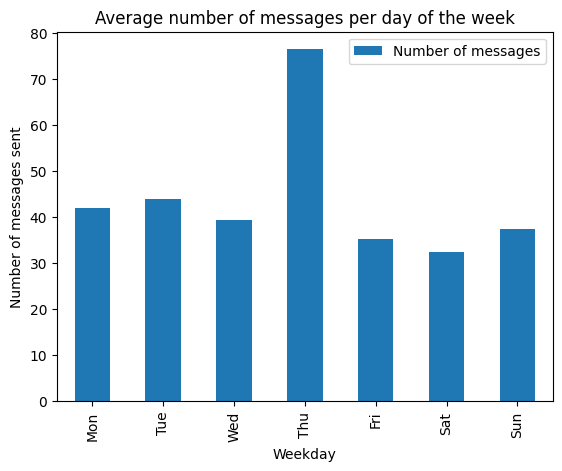

In [17]:
plotAvrgNumberOfMessagesInTimeFrame(df, "Day")

<Axes: xlabel='Datetime'>

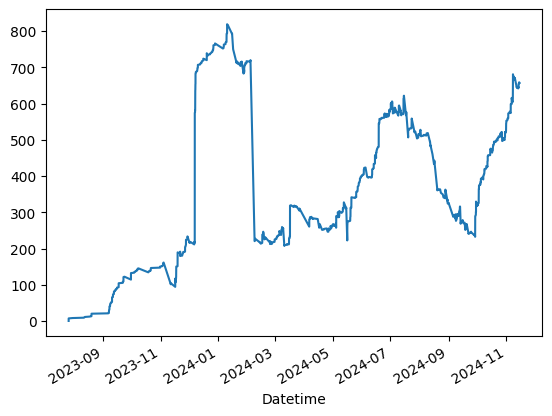

In [18]:
showUseOfWordsOverTime(df, "ich", time_frame_in_days=60)